# Training a CNN model on MNIST

#### Install dependencies

In [1]:
%pip install matplotlib seaborn torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


#### Prepare imports

In [2]:
import matplotlib.pyplot as plt # This is to load plotting functions
import seaborn as sns; sns.set() # This is to make the plots prettier
import torch # This is the ML library we will use
from torchvision import datasets # This is to access the MNIST dataset
from torchvision.transforms import ToTensor # This is used to transform data into a PyTorch tensor
from torch.utils.data import DataLoader # This is used to load the data efficiently

#### Select the device from GPU and CPU

In [3]:
# If GPU is available, it is chosen for computations, and if not, CPU will be used
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Download the MNIST dataset

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


##### Show example images from the dataset

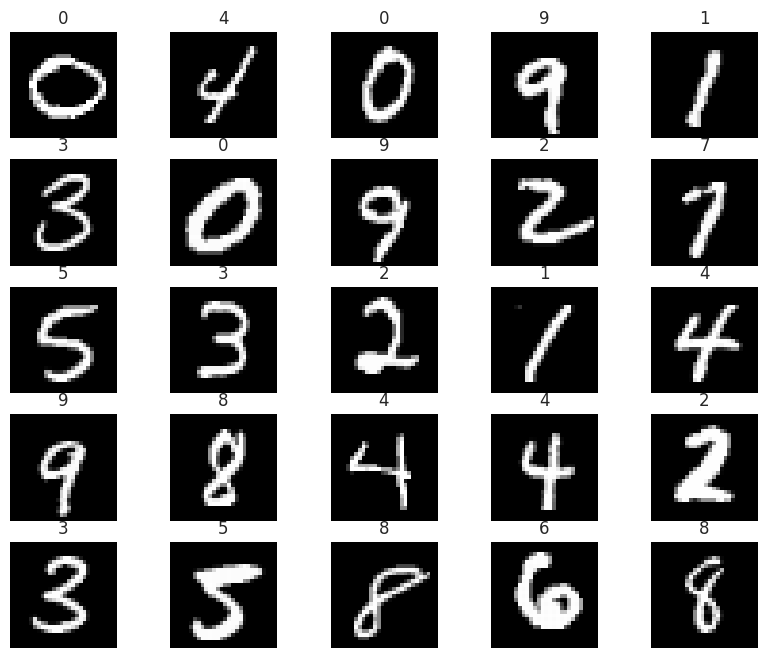

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Create data loaders

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=100, shuffle=True, num_workers=1
)

test_loader = (
    torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
)

#### Create an MLP classifier model with the following structure:

Flatten layer to create a vector from the input image (28x28)

Linear layer with 28 * 28 input dimensions and 256 output dimensions

ReLU activation layer

Linear layer with 256 input dimensions and 128 output dimensions

ReLU activation layer

Linear layer with 128 input dimensions and 10 output dimensions (number of classes)

We do not use softmax for the output layer because the CrossEntropyLoss function from PyTorch receives unnormalized logits.


<details>
<summary>Solution</summary>
    <code>
        torch.nn.Flatten(),<br>
        torch.nn.Linear(28 * 28, 256),<br>
        torch.nn.ReLU(),<br>
        torch.nn.Linear(256, 128),<br>
        torch.nn.ReLU(),<br>
        torch.nn.Linear(128, 10),<br>
    </code>
</details>

In [7]:
class MnistMlpClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.body = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )

    def forward(self, x):
        output = self.body(x)
        return output

In [8]:
# Instantiate the model
model_mlp = MnistMlpClassifier()
model_mlp

MnistMlpClassifier(
  (body): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

#### Create a loss function and an optimizer

In [9]:
learning_rate = 0.01

loss_func_mlp = torch.nn.CrossEntropyLoss()   
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)

#### Train the model

In [10]:
def train(num_epochs, model, loss_func, optimizer):

    model.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        # For each batch in the training data
        for i, (images, labels) in enumerate(train_loader):

            # Compute output and loss
            output = model(images)
            loss = loss_func(output, labels)

            # Clear gradients for this training step
            optimizer.zero_grad()

            # Compute gradients
            loss.backward()
            # Apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )
    
    print("Done.")

train(10, model_mlp, loss_func_mlp, optimizer_mlp)

Epoch [1/10], Step [100/600], Loss: 0.2718
Epoch [1/10], Step [200/600], Loss: 0.2328
Epoch [1/10], Step [300/600], Loss: 0.1889
Epoch [1/10], Step [400/600], Loss: 0.0685
Epoch [1/10], Step [500/600], Loss: 0.2423
Epoch [1/10], Step [600/600], Loss: 0.1326
Epoch [2/10], Step [100/600], Loss: 0.2405
Epoch [2/10], Step [200/600], Loss: 0.0820
Epoch [2/10], Step [300/600], Loss: 0.1850
Epoch [2/10], Step [400/600], Loss: 0.1064
Epoch [2/10], Step [500/600], Loss: 0.1347
Epoch [2/10], Step [600/600], Loss: 0.1184
Epoch [3/10], Step [100/600], Loss: 0.1666
Epoch [3/10], Step [200/600], Loss: 0.0975
Epoch [3/10], Step [300/600], Loss: 0.0667
Epoch [3/10], Step [400/600], Loss: 0.0560
Epoch [3/10], Step [500/600], Loss: 0.1397
Epoch [3/10], Step [600/600], Loss: 0.1646
Epoch [4/10], Step [100/600], Loss: 0.1370
Epoch [4/10], Step [200/600], Loss: 0.1596
Epoch [4/10], Step [300/600], Loss: 0.0899
Epoch [4/10], Step [400/600], Loss: 0.1249
Epoch [4/10], Step [500/600], Loss: 0.1126
Epoch [4/10

#### Now test the trained model on the test subset of MNIST

In [11]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        
        accuracy = correct / float(total)
        print('Test Accuracy of the model on the 10000 test images: %.2f%%' % (accuracy * 100))
test(model_mlp)

Test Accuracy of the model on the 10000 test images: 97.21%


#### Create a CNN classifier model with the following structure:

2D Convolutional layer with 1 input channel, 16 output channels, filter size of 5x5, stride 1 and padding 2

ReLU activation layer

2D Max Pooling layer of size 2x2

2D Convolutional layer with 16 input channels, 32 output channels, filter size of 5x5, stride 1 and padding 2

ReLU activation layer

2D Max Pooling layer of size 2x2

Flatten layer to create a vector from the tensor (32x7x7)

Linear layer with 32 * 7 * 7 input channels and 10 output dimensions (number of classes)

We do not use softmax for the output layer because the CrossEntropyLoss function from PyTorch receives unnormalized logits.

<details>
<summary>Solution</summary>
    <code>
    torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2),<br>
    torch.nn.ReLU(),<br>
    torch.nn.MaxPool2d(kernel_size=2),<br>
    torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2),<br>
    torch.nn.ReLU(),<br>
    torch.nn.MaxPool2d(kernel_size=2),<br>
    torch.nn.Flatten(),<br>
    torch.nn.Linear(32 * 7 * 7, 10),<br>
    </code>
</details>

In [12]:
class MnistCnnClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.body = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 7 * 7, 10),
        )

    def forward(self, x):
        output = self.body(x)
        return output

In [13]:
# Instantiate the model
model_cnn = MnistCnnClassifier()
model_cnn

MnistCnnClassifier(
  (body): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [14]:
learning_rate = 0.01

loss_func_cnn = torch.nn.CrossEntropyLoss()   
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

In [15]:
train(10, model_cnn, loss_func_cnn, optimizer_cnn)

Epoch [1/10], Step [100/600], Loss: 0.1302
Epoch [1/10], Step [200/600], Loss: 0.0657
Epoch [1/10], Step [300/600], Loss: 0.0825
Epoch [1/10], Step [400/600], Loss: 0.2120
Epoch [1/10], Step [500/600], Loss: 0.1508
Epoch [1/10], Step [600/600], Loss: 0.0853
Epoch [2/10], Step [100/600], Loss: 0.0409
Epoch [2/10], Step [200/600], Loss: 0.0759
Epoch [2/10], Step [300/600], Loss: 0.0804
Epoch [2/10], Step [400/600], Loss: 0.2665
Epoch [2/10], Step [500/600], Loss: 0.1435
Epoch [2/10], Step [600/600], Loss: 0.0336
Epoch [3/10], Step [100/600], Loss: 0.0234
Epoch [3/10], Step [200/600], Loss: 0.1207
Epoch [3/10], Step [300/600], Loss: 0.0419
Epoch [3/10], Step [400/600], Loss: 0.1013
Epoch [3/10], Step [500/600], Loss: 0.0583
Epoch [3/10], Step [600/600], Loss: 0.0345
Epoch [4/10], Step [100/600], Loss: 0.0213
Epoch [4/10], Step [200/600], Loss: 0.1194
Epoch [4/10], Step [300/600], Loss: 0.0257
Epoch [4/10], Step [400/600], Loss: 0.0545
Epoch [4/10], Step [500/600], Loss: 0.0290
Epoch [4/10

In [16]:
test(model_cnn)

Test Accuracy of the model on the 10000 test images: 98.42%
